# Exploration Guide

we start by importing the standard libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import shapely.ops
import shapely
import seaborn as sns
import itertools
from matplotlib.colors import ListedColormap
plt.rcParams["figure.figsize"] = (15,15)
sns.set()

### Restriction to 170 communities

we read the whole dataset and restrict ourselves to the 170 communities

In [3]:
vdf = gpd.read_parquet('../data/shanghai_villages_all.parquet')

In [4]:
df_aggregate = pd.read_csv('../data/CommunityAggregateData.csv')

In [5]:
df_aggregate.CommunityID14 = df_aggregate.CommunityID14.astype(str)

In [6]:
vdf100 = vdf.merge(df_aggregate, left_on='ad_code', right_on='CommunityID14', how='inner')

In [7]:
vdf100['sqminha'] = vdf100.green / vdf100.PopCommunity

### map of the 170 communities with index for smaller maps

In [8]:
my_cmap = ListedColormap(sns.palettes.mpl_palette('viridis'))

In [10]:
import contextily as ctx

with open('mapbox_token','r') as fp:
    mapbox_token = fp.read()
light_theme_mapbox = 'https://api.mapbox.com/styles/v1/shangdaemon/cj2sjwg9u000m2ro8tcc6ttx2/tiles/256/{z}/{x}/{y}@2x?access_token='+mapbox_token 

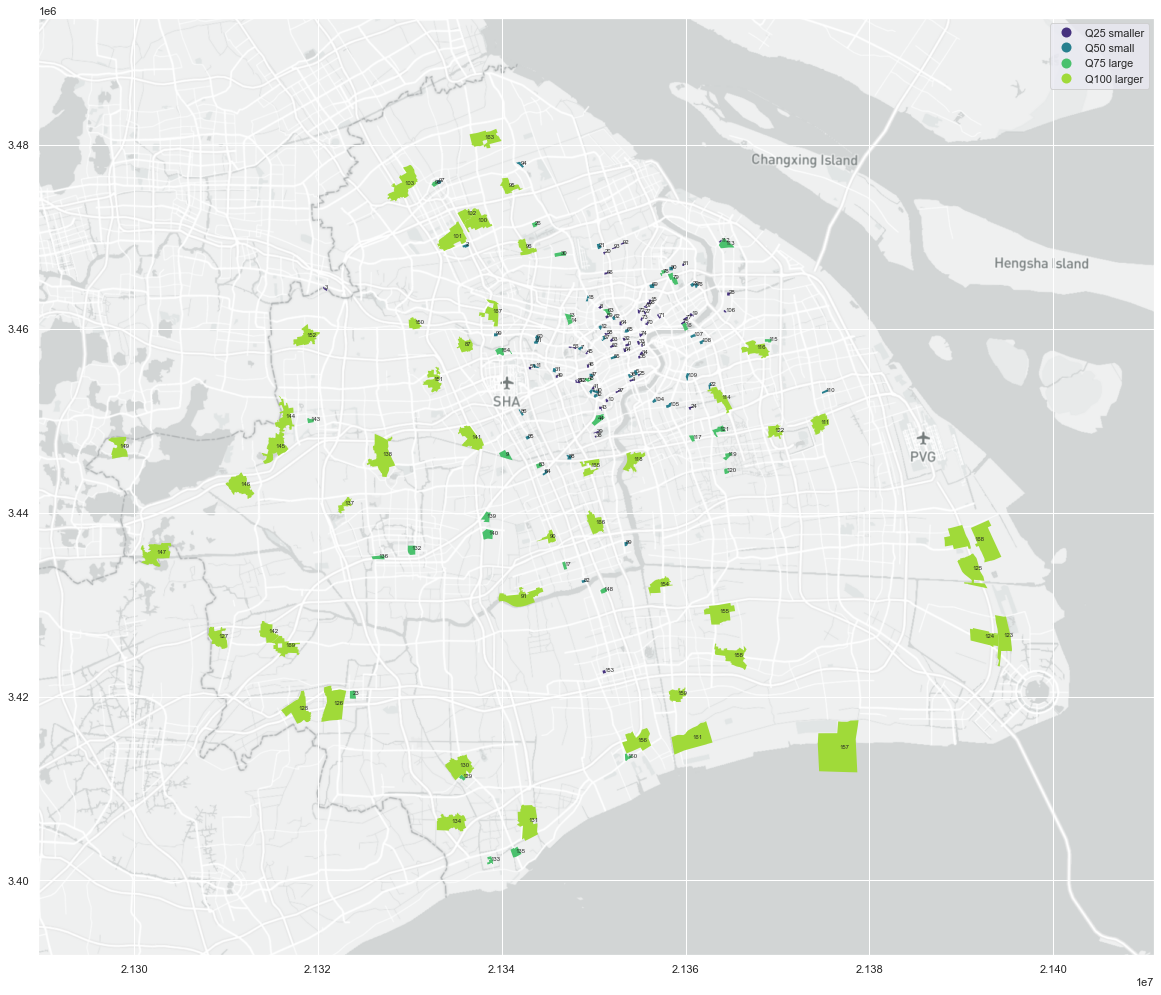

In [11]:
ax = vdf.plot(linewidth=0.2, color='whitesmoke',edgecolor='darkgrey',alpha=0, figsize=(20,20))
vdf100.plot(column='area_minus_water_quantile_classification', linewidth=0, cmap=my_cmap, legend=True, categorical=False, ax=ax)
ctx.add_basemap(ax, crs=4576, source='https://api.mapbox.com/styles/v1/shangdaemon/ckcmyzngh23uf1ipgx4z39d1z/tiles/256/{z}/{x}/{y}@2x?access_token='+mapbox_token)

for i in vdf100.index.to_list():
    ax.text(vdf100.iat[i,4].centroid.x, vdf100.iat[i,4].centroid.y, s=f'{i}', fontsize=6)

fig = ax.get_figure()
fig.savefig('villages-random-selection-map-mapbox-300dpi.pdf', dpi=300)

### Preparation of the standard scale indicators 

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [13]:
vdf100[['HealthComm', 'AnxietyComm', 'DepressionComm', 'GreenSatisficationComm', 'NeighborhoodSatisficationComm']] = scaler.fit_transform(vdf100[['HealthComm', 'AnxietyComm', 'DepressionComm', 'GreenSatisficationComm', 'NeighborhoodSatisficationComm']])

### create a map for each community in the index with the green polygons

In [14]:
vdf100.area_minus_water_quantile_classification.unique()

['Q25 smaller', 'Q50 small', 'Q75 large', 'Q100 larger']
Categories (4, object): ['Q25 smaller' < 'Q50 small' < 'Q75 large' < 'Q100 larger']

In [ ]:
for i in vdf100.index.tolist():
    vdf170_i = vdf100[vdf100.index == i]

    minx, miny, maxx, maxy = tuple(vdf170_i.geometry.bounds.values[0])
    minx-= 1000
    miny -= 1000
    maxx += 1000
    maxy += 1000
    vdf170_i = vdf170_i.append({'geometry_village':shapely.geometry.Polygon([(minx,maxy),(maxx,maxy),(maxx, miny),(minx, miny)])}, ignore_index=True)
    vdf170_i = vdf170_i.set_geometry('geometry_village')
    vdf170_i.crs = 4576

    vdf170_i = vdf170_i.to_crs(4326)


    facecolor = {'Q25 smaller':my_cmap(0), 'Q50 small':my_cmap(1), 'Q75 large':my_cmap(2), 'Q100 larger':my_cmap(3)}[vdf170_i.iat[0,26]]
    legend = f"{vdf170_i.head(1)[['PopCommunity','HealthComm','LifeSatisficationComm','AnxietyComm','DepressionComm','GreenSatisficationComm','NeighborhoodSatisficationComm','area_minus_water_quantile_classification']].T.to_string().strip()[1:].strip()}"

    ax = vdf170_i.tail(1).plot(figsize=(20, 20), alpha=0.0, color='purple', edgecolor='indigo')
    vdf170_i.head(1).plot(alpha=0.3, color='purple', edgecolor='indigo', ax=ax)
    vdf170_i.head(1).set_geometry('geometry_green').to_crs(4326).plot(alpha=0.8, color='forestgreen', edgecolor='darkgreen', ax=ax)
    ax.text(0.7,1.05,s=legend, color='black',bbox=dict(facecolor=facecolor), fontsize=14, transform=ax.transAxes)
    ax.text(0.3,1.05, s=f"{vdf170_i.iat[-1,4].centroid}", fontsize=18, fontweight='bold', transform=ax.transAxes)

    ctx.add_basemap(ax, crs=4326, source=light_theme_mapbox)
    fig = ax.get_figure()
    fig.savefig(f'village-{i}.pdf', dpi=300)